# Objective
**- To classify the given leaf image as healthy, late blight or early blight**<br>
**- Multiclass classification problem**<br>

# Data
**-The dataset is originally collected from
[kaggle.com](https://www.kaggle.com/arjuntejaswi/plant-village)**<br>
**- A subset of the original data is created which includes only the diseases of potato plants**<br>
**- Dataset used in this project -
[click here!](https://www.kaggle.com/ashokkumarpalivela/potato-diseases)**

#### Folder structure
- data
    - Late Blight
        - img1.png
        - img2.png
        - ...
    - Early Blight
        - img1.png
        - img2.png
        - ...
    - Healthy
        - img1.png
        - img2.png
        - ...

# Dependencies

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)
############ settings ############
data_dir = r"..\data"

batch_size = 32
img_height = 128
img_width = 128

2.6.0


# Data preprocessing

**- Loading and splitting data<br>**
**- Train:80% and Validation:20%**

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.


# EDA

In [3]:
def plot_distribution(y, title):
    a = Counter(y)
    y = ['Early_blight', 'Healthy', 'Late_blight']
    
    x = [a[i] for i in range(3)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='blue')
    plt.title(title)
    return plt.show()

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")

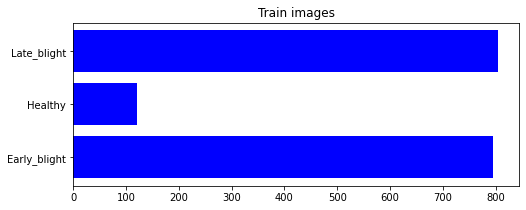

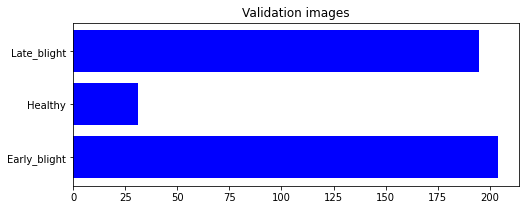

In [4]:
# Target distribution

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")

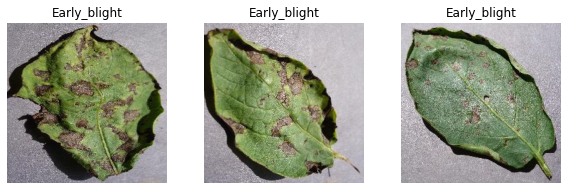

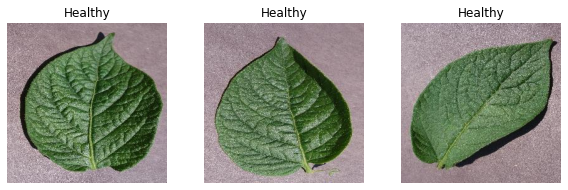

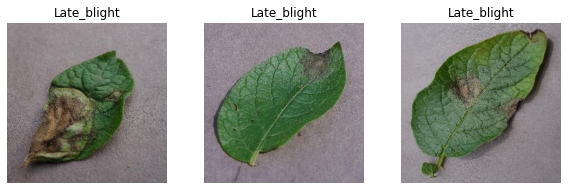

In [5]:
## Sample images
class_names = train_ds.class_names

for class_name in class_names:
    imgs = os.listdir(os.path.join(data_dir, class_name))[:3]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

# Model Training

In [6]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Model architecture

num_classes = 3

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')

])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=[earlystop_callback])

Epoch 1/20
54/54 [==============================] - 29s 511ms/step - loss: 0.7728 - accuracy: 0.6440 - val_loss: 0.4142 - val_accuracy: 0.8186
Epoch 2/20
54/54 [==============================] - 24s 448ms/step - loss: 0.3917 - accuracy: 0.8444 - val_loss: 0.3129 - val_accuracy: 0.8535
Epoch 3/20
54/54 [==============================] - 25s 468ms/step - loss: 0.2940 - accuracy: 0.8879 - val_loss: 0.3649 - val_accuracy: 0.8791
Epoch 4/20
54/54 [==============================] - 25s 457ms/step - loss: 0.2155 - accuracy: 0.9199 - val_loss: 0.1809 - val_accuracy: 0.9209
Epoch 5/20
54/54 [==============================] - 26s 479ms/step - loss: 0.1941 - accuracy: 0.9187 - val_loss: 0.2429 - val_accuracy: 0.9140
Epoch 6/20
54/54 [==============================] - 28s 510ms/step - loss: 0.1493 - accuracy: 0.9477 - val_loss: 0.2636 - val_accuracy: 0.9140
Epoch 7/20
54/54 [==============================] - 24s 452ms/step - loss: 0.1016 - accuracy: 0.9646 - val_loss: 0.2581 - val_accuracy: 0.9233

# Model Evaluation

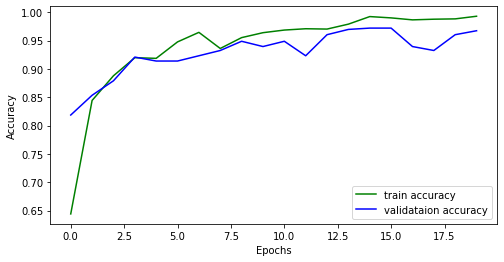

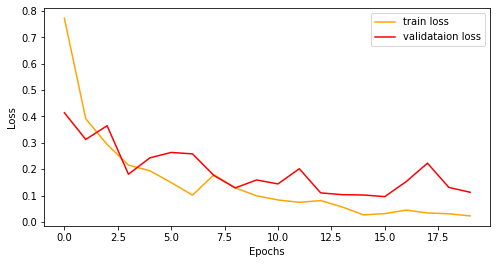

In [54]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
loss, acc = model.evaluate(val_ds, batch_size=batch_size)
print("validation accuracy :", round(acc, 2))
print("validation loss :", round(loss,2))

14/14 [==============================] - 2s 120ms/step - loss: 0.1123 - accuracy: 0.9674
validation accuracy : 0.97
validation loss : 0.11


In [19]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

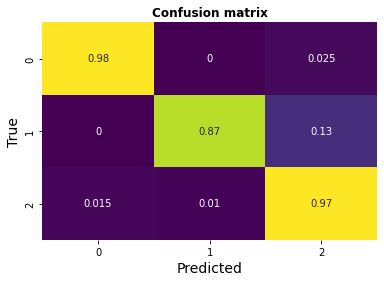

In [50]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [25]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       204
           1       0.93      0.87      0.90        31
           2       0.95      0.97      0.96       195

    accuracy                           0.97       430
   macro avg       0.96      0.94      0.95       430
weighted avg       0.97      0.97      0.97       430



# Post Processing

In [12]:
# Save
model.save("../application/static/models/model_v1.h5")

In [33]:
def prediction(img):
    class_names = ['Early_blight', 'Healthy', 'Late_blight']

    my_image = load_img(img, target_size=(img_height, img_width))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

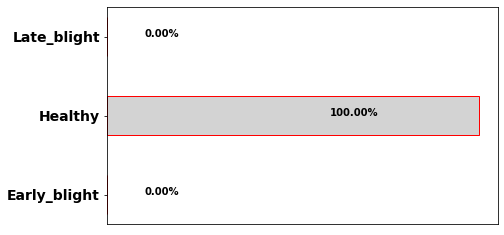

In [34]:
####### Prediction on single Image
img = '../data/Healthy/04481ca2-f94c-457e-b785-1ac05800b7ec___RS_HL 1930.JPG'
prediction(img)

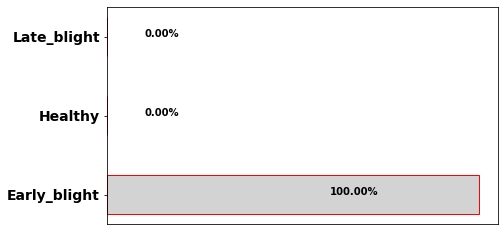

In [35]:
####### Prediction on single Image
img = '../data/Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG'
prediction(img)

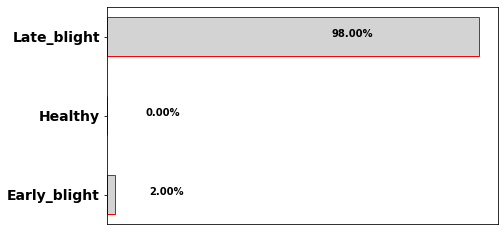

In [36]:
####### Prediction on single Image
img = '../data/Late_blight/01270f5c-a44b-4da7-9398-289088c197ab___RS_LB 2517.JPG'
prediction(img)